In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
from datetime import datetime
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer
from src.fitness_features_preprocessing import NGRAM_SCORE_PATTERN

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
# real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))

# regrown_game_asts = list(cached_load_and_parse_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl', grammar_parser, True, relative_path='..'))


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
print(fitness_df.shape)
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']
(100450, 549)


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.978689,0.985999,0.972647,0.982941,0.983447,0.985028,0.923947,0.920410,0.977171,0.988160
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.984116,0.984782,0.969335,0.980352,0.979375,0.985628,0.910105,0.933163,0.949498,0.964510
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.978814,0.982546,0.000000,0.000000,0.000000,0.000000,0.854408,0.866689,0.928334,0.945839
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.988970,0.988449,0.000000,0.000000,0.000000,0.000000,0.923947,0.920410,0.977171,0.988160
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.984601,0.983148,0.000000,0.000000,0.000000,0.000000,0.978064,0.979764,0.973707,0.988379


In [5]:
POSITIVES_FILE = 'interactive-beta.pddl'
NEGATIVES_FILE = 'ast-real-regrowth-samples-1024.pddl'

def create_filtered_df(df: pd.DataFrame, 
    filter_data_src_files: typing.Sequence[str] = (POSITIVES_FILE, NEGATIVES_FILE),
    ) -> pd.DataFrame:
    f_df = fitness_df[fitness_df.src_file.isin(filter_data_src_files)].reset_index(drop=True)
    f_df.loc[f_df.src_file == filter_data_src_files[0], 'real'] = 1
    return f_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [6]:
print(filtered_fitness_df.shape)
filtered_fitness_df.head()

(100450, 549)


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.978689,0.985999,0.972647,0.982941,0.983447,0.985028,0.923947,0.920410,0.977171,0.988160
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.984116,0.984782,0.969335,0.980352,0.979375,0.985628,0.910105,0.933163,0.949498,0.964510
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.978814,0.982546,0.000000,0.000000,0.000000,0.000000,0.854408,0.866689,0.928334,0.945839
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.988970,0.988449,0.000000,0.000000,0.000000,0.000000,0.923947,0.920410,0.977171,0.988160
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.984601,0.983148,0.000000,0.000000,0.000000,0.000000,0.978064,0.979764,0.973707,0.988379


In [ ]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == NEGATIVES_FILE].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In [ ]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

print(sum(never_change))

# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Change the random seed?
* See if the GPU is faster
* Try a different from of regularization?



['all_variables_defined', 'all_variables_used', 'all_preferences_used', 'adjacent_once_found', 'no_adjacent_same_modal', 'repeated_variables_found', 'nested_logicals_found', 'identical_logical_children_found', 'tautological_expression_found', 'redundant_expression_found', 'no_two_number_operations', 'section_without_pref_or_total_count_terminal', 'section_without_pref_or_total_count_scoring', 'section_exists_setup', 'section_exists_terminal', 'ast_ngram_full_n_7_score', 'ast_ngram_setup_n_5_score', 'ast_ngram_constraints_n_7_score', 'ast_ngram_terminal_n_5_score', 'ast_ngram_scoring_n_5_score']
Train tensor shape: torch.Size([78, 1025, 20]) | Test tensor shape: torch.Size([20, 1025, 20])
Fitting 5 folds for each of 24 candidates, totalling 120 fits


### Test results:

{'ecdf': -0.019239024390243907, 'game_rank': 0.971142590045929}

### CV results by overall ECDF:

,fitness__batch_size,fitness__beta,fitness__k,fitness__loss_function,fitness__lr,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
9,8,4,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.023106,0.005189,1,0.972626,0.003841,13
12,8,8,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.01,20,0.0,-0.023129,0.004641,2,0.972626,0.003825,13
14,8,8,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.01,20,0.0,-0.023188,0.004103,3,0.972748,0.003717,5
22,16,8,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.01,20,0.0,-0.023584,0.004993,4,0.972638,0.003755,11
21,16,8,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.023596,0.006319,5,0.972638,0.003721,11
2,4,4,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.01,20,0.0,-0.024394,0.005895,6,0.972602,0.003806,16
1,4,4,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.024636,0.002807,7,0.972724,0.003778,7
11,8,4,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.024863,0.006612,8,0.972614,0.003859,15
19,16,4,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.024979,0.006172,9,0.972590,0.003828,18
0,4,4,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.01,20,0.0,-0.025165,0.006470,10,0.972565,0.003831,20


### CV results by mean single game rank:

,fitness__batch_size,fitness__beta,fitness__k,fitness__loss_function,fitness__lr,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
5,4,8,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.037585,0.009592,24,0.972943,0.003469,1
7,4,8,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.031344,0.006688,20,0.972832,0.003694,2
4,4,8,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.01,20,0.0,-0.030412,0.004944,18,0.972785,0.003727,3
3,4,4,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.027324,0.007394,14,0.972760,0.003733,4
14,8,8,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.01,20,0.0,-0.023188,0.004103,3,0.972748,0.003717,5
23,16,8,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.027876,0.004450,16,0.972736,0.003702,6
1,4,4,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.024636,0.002807,7,0.972724,0.003778,7
15,8,8,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.032595,0.005685,22,0.972721,0.003806,8
6,4,8,512,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.01,20,0.0,-0.028653,0.006896,17,0.972699,0.003747,9
13,8,8,256,<function fitness_softmin_loss at 0x7f42e13f0b80>,0.03,20,0.0,-0.033562,0.005791,23,0.972698,0.003640,10


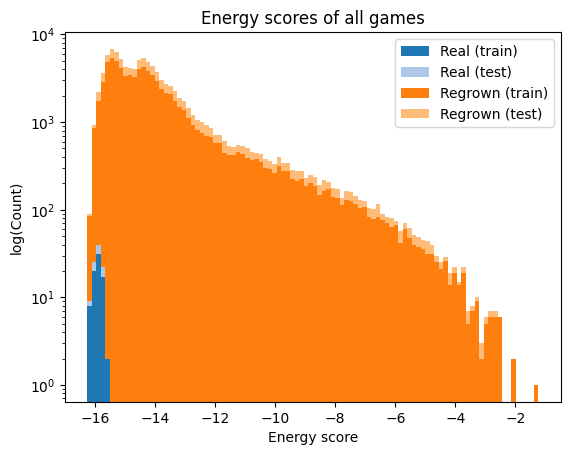

Weights mean: -0.698 +/- 1.740 with bias 0.010


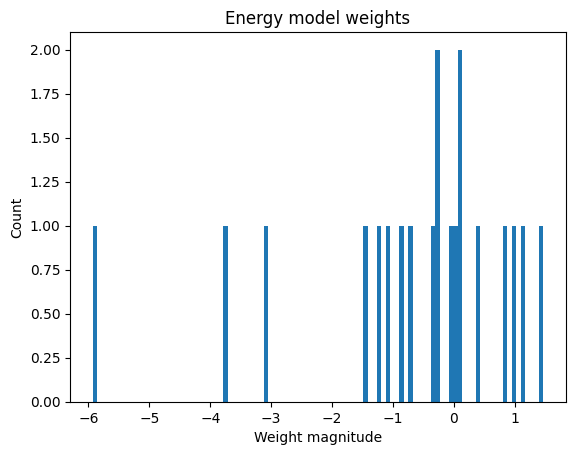

In [19]:
# test_param_grid = [
#     {
#         'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
#         'fitness__weight_decay': [0.0],  
#         'fitness__margin': [8, 16],
#         # 'fitness__beta': [0.25, 1, 2, 4],
#         'fitness__lr':  [1e-2, 3e-2],  # [1e-1, 3e-2, 1e-2, 3e-3],
#         'fitness__k': [256, 512],  # 128
#         'fitness__batch_size': [2, 4, 8],  # [1, 4, 8, 16],
#         # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
#         # 'fitness__dataset_energy_beta': [1, 3, 5],
#         # 'fitness__regularization_weight': [0.01, 0.05],
#     },
# ]

test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_softmin_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0],  
        # 'fitness__margin': [8, 16],
        'fitness__beta': [4, 8],
        'fitness__lr':  [1e-2, 3e-2],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [256, 512],  # 128
        'fitness__batch_size': [4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
        # 'fitness__dataset_energy_beta': [1, 3, 5],
        # 'fitness__regularization_weight': [0.01, 0.05],
    },
]



def build_regularization_function(ord: int = 1, threshold: float = 0):
    def regularization_function(model: nn.Module) -> torch.Tensor:
        w = model.fc1.weight.squeeze()  # type: ignore
        return torch.linalg.norm(w * (w.abs() >= threshold), ord)
    
    return regularization_function

regularizer = build_regularization_function(ord=1, threshold=0)

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none', n_epochs=3000, patience_epochs=10, 
    shuffle_negatives=True, 
    bias_init_margin_ratio=2,
    # device=torch.device('cuda:0'), 
    # regularizer=regularizer
    )
cv_kwargs = dict(refit='overall_ecdf', error_score='raise')  # , n_jobs=1)
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

feature_columns = [str(c) for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]
# for n in range(2, 7):
#     f = f'ast_ngram_n_{n}_score'
#     if f in feature_columns:
#         feature_columns.remove(f)


remove_all_ngram_scores = []  #  ('full',)
for score_type in ('full', 'setup', 'constraints', 'terminal', 'scoring'):
    col_names = [c for c in feature_columns if c.startswith(f'ast_ngram_{score_type}') and c.endswith('_score')]

    if score_type not in remove_all_ngram_scores:
        col_names = col_names[:-1]

    for col in col_names:
        feature_columns.remove(col)

other_features = ['all_variables_defined', 'all_variables_used',
    'all_preferences_used', 'no_adjacent_same_modal', 'adjacent_once_found',
    'repeated_variables_found', 'nested_logicals_found', 'identical_logical_children_found', 
    'no_two_number_operations', 'tautological_expression_found', 'redundant_expression_found',]
feature_columns = [c for c in feature_columns if 'score' in c or c.startswith('section_') or c in other_features]
print(feature_columns)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(
    # [fitness_df, mle_samples_df], 
    fitness_df, 
    test_param_grid, feature_columns=feature_columns,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs,
    energy_weighted_resampling=False, 
    random_seed=42,
    )

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)

In [20]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.squeeze().detach().cpu()
weight_indices = torch.argsort(weights)
found_positive = False
for i, idx in enumerate(weight_indices):
    print(f'{i:>2}.  {feature_columns[idx]} = {weights[idx].item():.3f}')
    if not found_positive and weights[weight_indices[i + 1]] > 0:
        found_positive = True
        print('=' * 60)


 0.  ast_ngram_full_n_7_score = -5.933
 1.  ast_ngram_constraints_n_7_score = -3.722
 2.  ast_ngram_scoring_n_5_score = -3.098
 3.  ast_ngram_terminal_n_5_score = -1.436
 4.  all_preferences_used = -1.214
 5.  all_variables_used = -1.104
 6.  no_two_number_operations = -0.894
 7.  ast_ngram_setup_n_5_score = -0.718
 8.  all_variables_defined = -0.340
 9.  nested_logicals_found = -0.264
10.  tautological_expression_found = -0.234
11.  section_without_pref_or_total_count_terminal = -0.056
12.  no_adjacent_same_modal = 0.017
13.  section_without_pref_or_total_count_scoring = 0.100
14.  identical_logical_children_found = 0.117
15.  adjacent_once_found = 0.389
16.  section_exists_setup = 0.867
17.  redundant_expression_found = 0.991
18.  repeated_variables_found = 1.107
19.  section_exists_terminal = 1.473


In [ ]:
filtered_fitness_df[(filtered_fitness_df.real == 1) & (filtered_fitness_df.section_without_pref_or_total_count_terminal > 0)]

In [ ]:
filtered_fitness_df.groupby('real').all_variables_defined.describe()

In [ ]:
filtered_fitness_df.groupby('real').no_adjacent_same_modal.describe()

In [ ]:
filtered_fitness_df.groupby('real').section_without_pref_or_total_count_terminal.describe()

In [ ]:
[(c, weights[feature_columns.index(c)].item()) for c in feature_columns if 'exists' in c]

In [ ]:
filtered_fitness_df.ast_ngram_scoring_n_5_score.hist(bins=30, by=filtered_fitness_df.real)

In [ ]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

In [ ]:
# cv.best_estimator_.fit(full_tensor)
SAVE_MODEL = True
if SAVE_MODEL:
    utils.save_model_and_feature_columns(cv, feature_columns)

In [ ]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
        'fitness__dataset_energy_beta': [1, 3, 5],
    },
]


cv_with_resampling, (train_tensor_with_resampling, test_tensor_with_resampling), test_results_with_resampling = utils.model_fitting_experiment(
    # [fitness_df, mle_samples_df], 
    fitness_df, 
    test_param_grid,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs,
    energy_weighted_resampling=True
    )


utils.visualize_cv_outputs(cv_with_resampling, train_tensor_with_resampling, test_tensor_with_resampling, test_results_with_resampling, histogram_title_note='energy weighted resampling')

### Checking the effect of regrowth depth

In [ ]:
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]
full_binarized_tensor = utils.df_to_tensor(binarized_df, feature_columns)
full_tensor_scores = cv_no_scaling_sq_sq.best_estimator_.transform(full_binarized_tensor).detach()

In [ ]:
energy_diffs = full_tensor_scores[:, 1:] - full_tensor_scores[:, 0].unsqueeze(1)
energy_diffs.ravel().shape

In [ ]:
def extract_regrowth_depth(game_text: str):
    game_id_start = game_text.find('(game')
    game_id_section = game_text[game_id_start:game_text.find(')', game_id_start)]
    regrowth_depth = game_id_section[game_id_section.rfind('-') + 2:]
    return int(regrowth_depth)

regrowth_depts = [extract_regrowth_depth(g) for g in regrown_game_texts]

In [ ]:
plt.scatter(regrowth_depts, energy_diffs.ravel().numpy(), s=5)

In [ ]:
map_samples_fitness_df = utils.load_fitness_data('../data/ast_mle_fitness_scores.csv')
binarized_map_samples_fitness_df = binarize_features(map_samples_fitness_df)

map_samples_binarized_arr = binarized_map_samples_fitness_df.loc[:, [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]]
map_samples_binarized_tensor = torch.from_numpy(map_samples_binarized_arr.values).float()

map_samples_binarized_energies = cv_no_scaling_sq_sq.best_estimator_.transform(map_samples_binarized_tensor.unsqueeze(1)).squeeze()

In [ ]:
histogram_log_y = True
histogram_title_base = 'Binarized features with MAP games, square-square loss'

train_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
test_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
train_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore
test_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore

hist_scores = [train_positive_scores, test_positive_scores, 
               train_negative_scores.flatten(), test_negative_scores.flatten(),
               map_samples_binarized_energies.detach().numpy()] 

labels = ['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)', 'MAP samples']

cm = plt.get_cmap('tab20')  # type: ignore
colors = cm.colors[:5]

plt.hist(hist_scores, label=labels, stacked=True, bins=100, color=colors)  # type: ignore
plt.title(histogram_title_base)

plt.xlabel('Energy score')

if histogram_log_y:
    plt.ylabel('log(Count)')
    plt.semilogy()
else:
    plt.ylabel('Count')

plt.legend(loc='best')
plt.show()

In [ ]:
weight_threshold = 1
weights = cv_no_scaling_sq_sq.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
weights_above_threshold = (weights.abs() > weight_threshold).numpy()
feature_columns = [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
features_with_weight_above_threshold = [feature_columns[i] for i in range(len(feature_columns)) if weights_above_threshold[i]]

with open('../data/features_with_weight_above_threshold_2022_01_24.txt', 'w') as f:
    f.write('\n'.join(features_with_weight_above_threshold))
    


In [ ]:
full_binarized_tensor = utils.df_to_tensor(binarized_df, [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS])
test_negative_scores_tensor = torch.tensor(test_negative_scores)
test_positive_scores_tensor = torch.tensor(test_positive_scores)
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]

In [ ]:
torch.topk((test_negative_scores_tensor - test_positive_scores_tensor.unsqueeze(-1)).ravel(), 30, largest=False)

In [ ]:
test_negative_scores_tensor.ravel()[836] == test_negative_scores_tensor[836 // 64, 836 % 64]

In [ ]:
utils.evaluate_energy_contributions(
    cv_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq, 1036,
    feature_columns, full_binarized_tensor, real_game_texts, regrown_game_texts,
)

In [ ]:
fitness_df.columns

In [ ]:
# [c for c in fitness_df.columns if 'arg_types' in c]
fitness_df.columns.get_loc('ast_ngram_constraints_n_6_score')

In [ ]:
from argparse import Namespace
from src.fitness_features import *
# from src.fitness_ngram_models import TextNGramModel, TextMultiNGramModel, ASTMultiNGramModel, NGramASTParser

# with gzip.open('../models/fitness_featurizer_2023_02_02.pkl.gz', 'rb') as f:
#     featurizer = pickle.load(f)


In [ ]:
args = Namespace(no_binarize=False, no_merge=True)
featurizer = build_fitness_featurizer(args)

In [ ]:
np.seterr(all='raise')
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
# _ = [featurizer.parse(game_asts[74], 'interactive-beta.pddl', return_row=False) for _ in range(1000)]

In [ ]:
np.seterr(all='raise')
_ = [featurizer.parse(regrown_game_asts[i], 'ast-real-regrowth-samples.pddl', return_row=False) for i in range(len(regrown_game_asts))]

In [ ]:
np.seterr(all='raise')
%prun _ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
# _ = [featurizer.parse(game_asts[74], 'interactive-beta.pddl', return_row=False) for _ in range(1000)]

In [ ]:
d = featurizer.to_df()

In [ ]:
d = d.assign(original_game_name=d.game_name)  # real=fitness_df.src_file == 'interactive-beta.pddl',
d.original_game_name.where(
    d.game_name.apply(lambda s: (s.count('-') <= 1) or (s.startswith('game-id') and s.count('-') >= 2)),
    d.original_game_name.apply(lambda s: s[:utils._find_nth(s, '-', 2)]),
    inplace=True)

In [ ]:
d[[c for c in d.columns if 'all_variables' in c or 'repeated_variables' in c]].describe()

In [ ]:
for original_game_name in d.original_game_name.unique():
    original_game_scoring_score = d[d.game_name == original_game_name].ast_ngram_scoring_n_5_score.max()
    sub_frame = d.loc[(d.original_game_name == original_game_name) & (d.real == 0) & (d.ast_ngram_scoring_n_5_score > original_game_scoring_score), 'ast_ngram_scoring_n_5_score']
    if len(sub_frame) > 0:
        print(original_game_name)
        print(sub_frame)


In [ ]:
d.groupby('real').ast_ngram_scoring_n_5_score.describe()

In [ ]:
d[d.section_exists_setup == 0].ast_ngram_setup_n_5_score.value_counts()

In [ ]:
!ls -la /tmp/gd1279/fitness_features

In [ ]:
d = featurizer.to_df()
temp_df = pd.read_csv('/tmp/gd1279/fitness_features/fitness_features_1024_regrowths.csv.gz_0.temp.csv')
temp_df.columns = d.columns
temp_df = utils._add_original_game_name_column(temp_df)
d = utils._add_original_game_name_column(d)
temp_df.head()

In [ ]:
for original_game_name in d.original_game_name.unique()[1:]:
    original_game_scoring_score = d[d.game_name == original_game_name].ast_ngram_scoring_n_5_score.max()
    if original_game_scoring_score == 0:
        print(original_game_name)
        sub_frame = temp_df.loc[(temp_df.original_game_name == original_game_name) & (temp_df.real == 0) & (temp_df.ast_ngram_scoring_n_5_score > original_game_scoring_score),
                                ['game_name', 'original_game_name', 'ast_ngram_scoring_n_5_score']]
        if len(sub_frame) > 0:
            print(original_game_name, len(sub_frame))
            break

In [ ]:
sub_frame.head()

In [ ]:
game_index = 65
negative_index = 470

pos_r = featurizer.parse(game_asts[game_index], 'test.pddl', return_row=True, preprocess_row=False)
neg_r = featurizer.parse(regrown_game_asts[game_index * 1024 + negative_index], 'test.pddl', return_row=True, preprocess_row=False)

In [ ]:
with open('../models/ast_7_ngram_model_2023_03_06.pkl', 'rb') as f:
    ngram_model = pickle.load(f)


In [ ]:
from ast_parser import ASTParentMapper
parent_mapper = ASTParentMapper()
parent_mapper(game_asts[game_index])

In [ ]:
r = featurizer.parse(game_asts[17], 'test.pddl', return_row=True, preprocess_row=False)

In [ ]:
{k: v for k, v in r.items() if k.startswith('section_without')}